# Centroid alignment in both x&y using Xopt/BAX

# Imports

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('C:\\Users\\Dylan\\SLAC') #parent directory containing emitopt module

import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator

from xopt.evaluator import Evaluator

import time
import numpy as np
import random

# Notebook settings

In [2]:
noise = False #whether to add noise to the ground-truth beam size function outputs
n_obs_init = 3 #number of random initial observations for GP model
n_samples = 100 #number of posterior samples for BAX
rand_seed = 0

#random seeds for reproducibility 
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) #only affects initial random observations through Xopt
random.seed(rand_seed)

# Build test function from single-quadrupole optical beam size model 
Here we define a simple ground-truth beam size function for our optimization problem, where we attempt to find the location in tuning parameter space with minimal emittance. Note that the function "test_func" used to evaluate the ground-truth beam size function takes a dictionary as input and returns a dictionary as the output.

In [3]:
# define test functions
from emitopt.resources.test_funcs import centroid_position

trim_name_x = 'trimx'
trim_name_y = 'trimy'
quad_name = 'quad'

def evaluate_centroid_position(input_dict):
    return centroid_position(input_dict, trim_name_x, trim_name_y, quad_name)

# Construct vocs

In [4]:
variables = {'trimx': [-2,2],
             'trimy': [-2,2],
             'quad': [-3,3]
            }

#construct vocs
vocs = VOCS(
    variables = variables,
    observables = ['xpos', 'ypos']
)

meas_dims = [vocs.variable_names.index('quad')]
print('variable_names =', vocs.variable_names)
print('domain =\n', vocs.bounds.T)
print('meas_dims =', meas_dims)

variable_names = ['quad', 'trimx', 'trimy']
domain =
 [[-3.  3.]
 [-2.  2.]
 [-2.  2.]]
meas_dims = [0]


# Prepare generator.
In this example, we use a specialty covariance module (Linear ProductKernel) for our beam size model.

In [5]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from gpytorch.priors.torch_priors import GammaPrior
from xopt.generators.bayesian.bax_generator import BaxGenerator
from emitopt.algorithms import ScipyBeamAlignment
import copy

# prepare custom covariance module
# covar_module = PolynomialKernel(power=1)
covar_module = (PolynomialKernel(power=1, active_dims=[0]) * PolynomialKernel(power=1, active_dims=[1]) *
                PolynomialKernel(power=1, active_dims=[2])
               )
scaled_covar_module_x = ScaleKernel(covar_module)   
scaled_covar_module_y = copy.deepcopy(scaled_covar_module_x)

# prepare options for Xopt generator
covar_module_dict = {'xpos': scaled_covar_module_x,
                    'ypos': scaled_covar_module_y}
# covar_module_dict = {}
model_constructor = StandardModelConstructor(covar_modules=covar_module_dict, use_low_noise_prior=True)

algo = ScipyBeamAlignment(meas_dims=meas_dims, n_samples=n_samples, x_key='xpos', y_key='ypos')

# Construct generator, evaluator, Xopt objects

In [6]:
#construct BAX generator
generator = BaxGenerator(vocs=vocs, gp_constructor=model_constructor, algorithm=algo)

#construct evaluator
evaluator = Evaluator(function=evaluate_centroid_position)

#construct Xopt optimizer
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

In [7]:
vocs.variables

{'trimx': [-2.0, 2.0], 'trimy': [-2.0, 2.0], 'quad': [-3.0, 3.0]}

In [8]:
# input_dict = {'trimx':0.2, 'trimy':0.2, 'quad':0}
def init_step_pattern(vocs, start_point, step_sizes):
    """
    Function that produces an list of input dicts with a starting point and subsequent single-dimensional 
    steps in each variable specified by list of step_sizes.
    
    Inputs:
        vocs: the vocs object from xopt
        start_point: a list of length len(vocs.variable_names) specifying the initial point to evaluate.
                    Values must be ordered according to the order of variables given by vocs.variable_names.
        step_sizes: a list of length len(vocs.variable_names) specifying the step sizes to take for the
                    subsequent evaluations. Values must be ordered according to the order of variables given 
                    by vocs.variable_names. Positive step sizes correspond to steps in positive direction.
                    Negative step sizes will be in the negative direction.
    """
    input_dicts = [{name:val for name, val in zip(vocs.variable_names, start_point)}]
    for i in range(len(vocs.variable_names)):
        step = {name:val for name, val in zip(vocs.variable_names, start_point)}
        step[vocs.variable_names[i]] = start_point[i] + step_sizes[i]
        input_dicts += [step]
    return input_dicts
input_dicts = init_step_pattern(vocs, [0, 0, 0], [-1, 0.2, 0.6])
X.evaluate_data(input_dicts)

,quad,trimx,trimy,xpos,ypos,xopt_runtime,xopt_error
0,0,0.0,0.0,100.0,100.0,4.000000e-06,False
1,-1,0.0,0.0,0.0,200.0,1.700000e-06,False
2,0,0.2,0.0,120.0,100.0,8.000006e-07,False
3,0,0.0,0.6,100.0,160.0,5.000002e-07,False


In [9]:
start_point = [0.2, 0.2, 0]
{name:val for name, val in zip(vocs.variable_names, start_point)}

{'quad': 0.2, 'trimx': 0.2, 'trimy': 0}

In [10]:
X.random_evaluate(n_obs_init)

,trimx,trimy,quad,xpos,ypos,xopt_runtime,xopt_error
0,-0.195254,-0.179533,0.374477,110.610463,51.322137,3.400000e-06,False
1,-0.860757,0.305381,-2.350638,-18.806626,437.385853,7.999997e-07,False
2,-0.411054,-0.583576,-2.781977,-104.948885,157.490410,4.999993e-07,False


In [11]:
X.data

,quad,trimx,trimy,xpos,ypos,xopt_runtime,xopt_error
0,0.000000,0.000000,0.000000,100.000000,100.000000,4.000000e-06,False
1,-1.000000,0.000000,0.000000,0.000000,200.000000,1.700000e-06,False
2,0.000000,0.200000,0.000000,120.000000,100.000000,8.000006e-07,False
3,0.000000,0.000000,0.600000,100.000000,160.000000,5.000002e-07,False
4,0.374477,-0.195254,-0.179533,110.610463,51.322137,3.400000e-06,False
5,-2.350638,-0.860757,0.305381,-18.806626,437.385853,7.999997e-07,False
6,-2.781977,-0.411054,-0.583576,-104.948885,157.490410,4.999993e-07,False


In [12]:
X.generator.vocs.output_names

['xpos', 'ypos']

In [13]:
X.step()

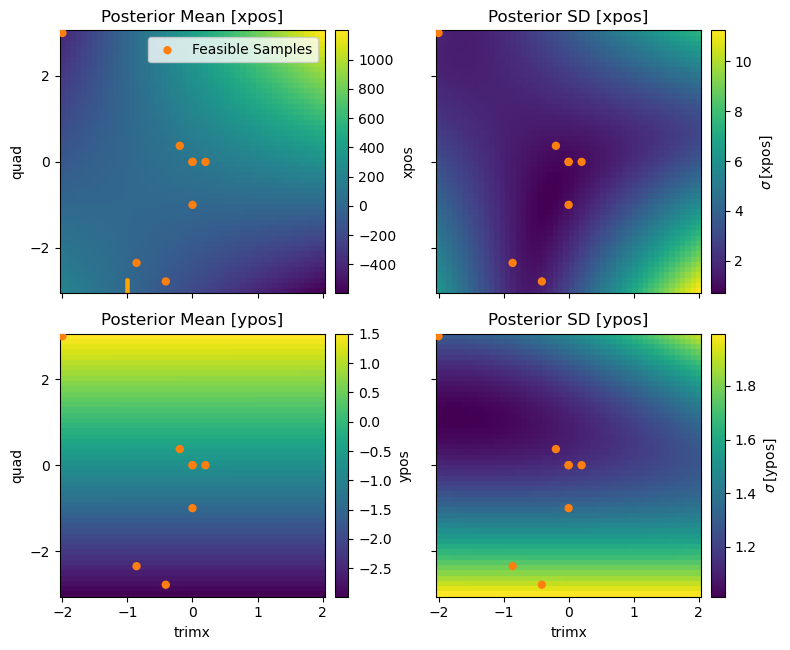

In [14]:
from xopt.generators.bayesian.visualize import visualize_generator_model
model = X.generator.train_model()
fig, ax = visualize_generator_model(X.generator, variable_names=['trimx', 'quad'], show_acquisition=False)

x_tuning_best = X.generator.algorithm_results['x_tuning_best']
for x_tuning in x_tuning_best:
    ax[0,0].axvline(x_tuning[0,0], c='orange', ymax=0.05)

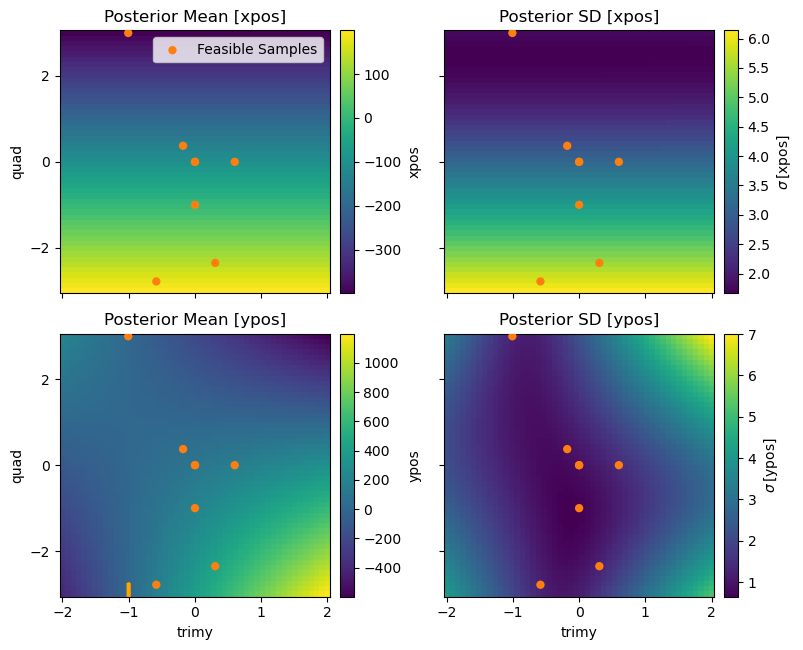

In [15]:
from xopt.generators.bayesian.visualize import visualize_generator_model
model = X.generator.train_model()
fig, ax = visualize_generator_model(X.generator, variable_names=['trimy', 'quad'], show_acquisition=False)

x_tuning_best = X.generator.algorithm_results['x_tuning_best']
for x_tuning in x_tuning_best:
    ax[1,0].axvline(x_tuning[0,1], c='orange', ymax=0.05)

(<Figure size 400x370 with 1 Axes>,
 <Axes: xlabel='trimx', ylabel='Virtual Objective'>)

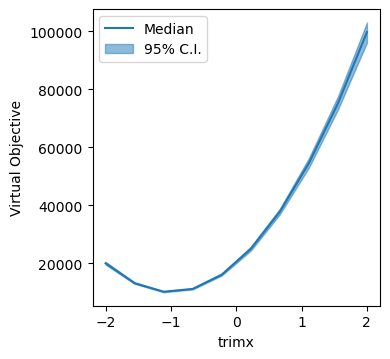

In [16]:
from xopt.generators.bayesian.bax.visualize import visualize_virtual_objective
visualize_virtual_objective(X.generator,['trimx'],reference_point={'trimx':0, 'trimy':0, 'quad':0})